# Turing Target Practice

## Model

In [1]:
] activate "."

  Activating project at `~/PhD/MicroCanonicalHMC.jl`


In [2]:
# The statistical inference frame-work we will use
using Turing
using Interpolations
using ForwardDiff
using LinearAlgebra
#using StatsPlots
using PyPlot
using Distributed

using Revise
using MicroCanonicalHMC

[ Info: Precompiling MicroCanonicalHMC [234d2aa0-2291-45f7-9047-6fa6f316b0a8]


In [3]:
fs8_zs = [0.38, 0.51, 0.61, 1.48, 0.44, 0.6, 0.73, 0.6, 0.86, 0.067, 1.4]
fs8_data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482]
fs8_cov = [0.00203355 0.000811829 0.000264615 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.000811829 0.00142289 0.000662824 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 
           0.000264615 0.000662824 0.00118576 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.002025 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0064 0.00257 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.00257 0.003969 0.00254 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.00254 0.005184 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0144 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0121 0.0 0.0; 
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.003025 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.013456000000000001];

In [4]:
function make_fs8(Ωm, σ8; Ωr=8.24*10^-5)
    # ODE solution for growth factor
    x_Dz = LinRange(0, log(1+1100), 300)
    dx_Dz = x_Dz[2]-x_Dz[1]
    z_Dz = @.(exp(x_Dz) - 1)
    a_Dz = @.(1/(1+z_Dz))
    aa = reverse(a_Dz)
    e =  @.(sqrt.(abs(Ωm)*(1+z_Dz)^3+Ωr*(1+z_Dz)^4+(1-Ωm-Ωr)))
    ee = reverse(e)

    dd = zeros(typeof(Ωm), 300)
    yy = zeros(typeof(Ωm), 300)
    dd[1] = aa[1]
    yy[1] = aa[1]^3*ee[end]

    for i in 1:(300-1)
        A0 = -1.5 * Ωm / (aa[i]*ee[i])
        B0 = -1. / (aa[i]^2*ee[i])
        A1 = -1.5 * Ωm / (aa[i+1]*ee[i+1])
        B1 = -1. / (aa[i+1]^2*ee[i+1])
        yy[i+1] = (1+0.5*dx_Dz^2*A0*B0)*yy[i] + 0.5*(A0+A1)*dx_Dz*dd[i]
        dd[i+1] = 0.5*(B0+B1)*dx_Dz*yy[i] + (1+0.5*dx_Dz^2*A0*B0)*dd[i]
    end

    y = reverse(yy)
    d = reverse(dd)

    Dzi = LinearInterpolation(z_Dz, d./d[1], extrapolation_bc=Line())
    fs8zi = LinearInterpolation(z_Dz, -σ8 .* y./ (a_Dz.^2 .*e.*d[1]),
                                 extrapolation_bc=Line())
    return fs8zi
end

make_fs8 (generic function with 1 method)

In [5]:
@model function model(data; cov = fs8_cov) 
    # Define priors
    #KiDS priors
    Ωm  ~ Uniform(0.01, 0.6)
    σ8 ~ Normal(0.8, 0.3)
    fs8_itp = make_fs8(Ωm, σ8)
    theory = fs8_itp(fs8_zs)
    data ~ MvNormal(theory, cov)
end;

In [6]:
stat_model = model(fs8_data)

DynamicPPL.Model{typeof(model), (:data, :cov), (:cov,), (), Tuple{Vector{Float64}, Matrix{Float64}}, Tuple{Matrix{Float64}}, DynamicPPL.DefaultContext}(model, (data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482], cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001]), (cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001],), DynamicPPL.DefaultContext())

## Sampling

In [7]:
target = TuringTarget(stat_model; compute_MAP=true);

In [8]:
samples_mchmc = Sample(MCHMC(varE_wanted=1.0), target, 100000;
                       file_name="Turing_sequential_samples.txt",
                       dialog=true);

[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
[ Info: Found sigma: [0.45043479852953805, 0.06088870443747066] ✅


eps: 0.5 --> VarE: 6.033181305056869
eps: 0.0032590208365153688 --> VarE: 0.01656271309481849
eps: 0.008305361564014043 --> VarE: 0.05049327119706957
eps: 0.01961021285810106 --> VarE: 0.12190559158264604
eps: 0.04175559089974464 --> VarE: 0.327893693263643
eps: 0.07239284429193005 --> VarE: 0.6636282709176013
eps: 0.0940732773419578 --> VarE: 0.8910668465001548
eps: 0.10197969141864667 --> VarE: 1.0191692901315408


[ Info: Found eps: 0.10197969141864667 ✅


samples: 100--> ESS: 0.015079107889772044
samples: 203--> ESS: 0.009476552905827237
samples: 310--> ESS: 0.01055780683740542
samples: 420--> ESS: 0.014238750764270423
samples: 534--> ESS: 0.0167395941553406
samples: 652--> ESS: 0.01699632045243629


[ Info: Found L: 2.4000416255749917 ✅


In [9]:
Wms_mchmc = [sample[1] for sample in samples_mchmc]
s8s_mchmc = [sample[2] for sample in samples_mchmc];

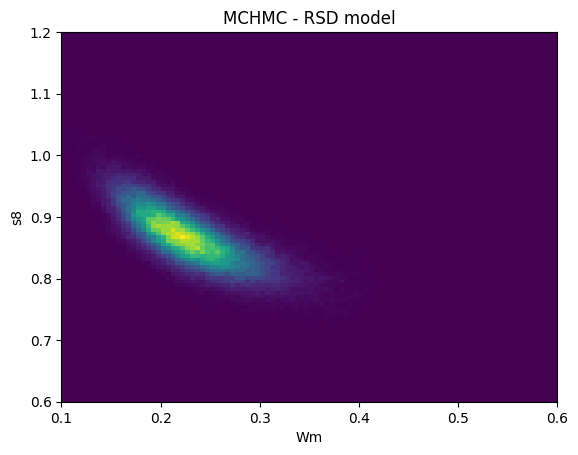

In [10]:
plt.hist2d(Wms_mchmc, s8s_mchmc, bins=100, range=[[0.1, 0.6],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("MCHMC - RSD model");

In [11]:
samples_ensemble_mchmc = Sample(MCHMC(100; varE_wanted=0.05), target, 1000, 100;
   monitor_energy=true, 
   dialog=true);

[ Info: Burn-in started ⏳
[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
┌ Warning: L-tuning not Implemented
└ @ MicroCanonicalHMC ~/PhD/MicroCanonicalHMC.jl/src/ensemble/tuning.jl:41
[ Info: Found L: 1.4142135623730951 ✅


eps: 0.5 --> VarE: 1.2642885260084056
eps: 0.23283256088322746 --> VarE: 0.9610337387525963
eps: 0.15017040977432647 --> VarE: 7.5130611145890045
eps: 0.000263445333103221 --> VarE: 6.80142642979657e-5
eps: 0.00040510298946182043 --> VarE: 0.00020632116003485435
eps: 0.000609926089338098 --> VarE: 0.0005375487772307147
eps: 0.0008999322951953261 --> VarE: 0.0012214130790458855
eps: 0.0013022174201772008 --> VarE: 0.00238637129295989
eps: 0.0018491589547399551 --> VarE: 0.0037508629952188034
eps: 0.002578935355913807 --> VarE: 0.00494321082862945
eps: 0.003536150854897524 --> VarE: 0.006041278151295948
eps: 0.004771400730013563 --> VarE: 0.009009717493616488
eps: 0.00633390320554915 --> VarE: 0.022060723252310524
eps: 0.008233533798780505 --> VarE: 0.06469181914221303
eps: 0.010334275613943442 --> VarE: 0.15440770405896112
eps: 0.012269078516508925 --> VarE: 0.3158438214729835
eps: 0.01338415272443535 --> VarE: 0.3990948403451654
eps: 0.01400495205732713 --> VarE: 0.44988036072861876
ep

[ Info: VarE condition met during eps tuning at step: 19
[ Info: Found eps: 0.014308200975354927 ✅


Initial Virial loss: 15057.698046057289
Initial sigma: [2.016664037899652, 0.30266817367941684]
Virial loss: 120.30256523964805 --> Relative improvement: 0.019617397016556404
Sigma --> [2.009979981613586, 0.30047670187338044]
Virial loss: 117.91291476236249 --> Relative improvement: 0.019863670176319737
Sigma --> [2.0062349625645557, 0.2988439320804068]
Virial loss: 115.57783786716318 --> Relative improvement: 0.019803402366105005
Sigma --> [2.003086106937867, 0.2973680106006425]
Virial loss: 113.30434209457884 --> Relative improvement: 0.019670689593599522
Sigma --> [2.000121540023343, 0.2959655008388592]
Virial loss: 111.09488312710569 --> Relative improvement: 0.019500214436873442
Sigma --> [1.9972216607707713, 0.29460748265550163]
Virial loss: 108.95030752702088 --> Relative improvement: 0.01930399978576114
Sigma --> [1.9943417404173645, 0.2932810480279677]
Virial loss: 106.87070013816701 --> Relative improvement: 0.01908766882863644
Sigma --> [1.991462121223972, 0.2919794393887036

Sigma --> [1.811880193786594, 0.23367486633561918]
Virial loss: 32.78545108628609 --> Relative improvement: 0.01934523045953107
Sigma --> [1.808838029099761, 0.23295465899721932]
Virial loss: 32.16177836318766 --> Relative improvement: 0.019022850149507553
Sigma --> [1.8057971040403022, 0.2322411890073997]
Virial loss: 31.562627005570732 --> Relative improvement: 0.01862929813305081
Sigma --> [1.8027581704298052, 0.23153440619467908]
Virial loss: 30.990217526102047 --> Relative improvement: 0.018135672907317102
Sigma --> [1.7997219400332714, 0.23083425940844193]
Virial loss: 30.446535024637576 --> Relative improvement: 0.017543681357078067
Sigma --> [1.7966890636826138, 0.23014069930445566]
Virial loss: 29.93224643013161 --> Relative improvement: 0.01689153114105757
Sigma --> [1.7936601435013315, 0.22945368104682573]
Virial loss: 29.446354952855707 --> Relative improvement: 0.016233044132189622
Sigma --> [1.790635769535375, 0.22877316427046573]
Virial loss: 28.986474271123992 --> Relat

┌ Warning: Maximum number of steps reached during burn-in
└ @ MicroCanonicalHMC ~/PhD/MicroCanonicalHMC.jl/src/ensemble/tuning.jl:197
[ Info: Found sigma: [1.7182132882673327, 0.2136974651963508] ✅


eps: 0.014308200975354927 --> VarE: 0.0007219954936799703
eps: 0.015030941935597727 --> VarE: 0.0008140795639055681
eps: 0.01578873628742933 --> VarE: 0.0009162308172811219
eps: 0.01658304125115618 --> VarE: 0.0010289144319960601
eps: 0.017415343837070465 --> VarE: 0.0011516796634962866
eps: 0.018287174509975766 --> VarE: 0.001281836815040825
eps: 0.019200150755948758 --> VarE: 0.0014125763713974423
eps: 0.020156071426651333 --> VarE: 0.0015324946772023358
eps: 0.02115704738804035 --> VarE: 0.00163092966343338
eps: 0.022205547169453544 --> VarE: 0.0017073920162342688
eps: 0.023304226480787754 --> VarE: 0.001771711022477757
eps: 0.024455692896587722 --> VarE: 0.0018337800826202012
eps: 0.02566246060031249 --> VarE: 0.0015375949514979848
eps: 0.026936753416695068 --> VarE: 0.0015655991847418217
eps: 0.028273530611976818 --> VarE: 0.001589909254701836
eps: 0.029675925968077117 --> VarE: 0.0016113467959866744
eps: 0.031147213807621314 --> VarE: 0.0016396949531619362
eps: 0.0326905191594280

[ Info: VarE condition met during eps tuning at step: 43
[ Info: Found eps: 0.07912430753116953 ✅


In [12]:
Wms_ensemble_mchmc = [sample[1] for sample in samples_ensemble_mchmc]
s8s_ensemble_mchmc = [sample[2] for sample in samples_ensemble_mchmc];

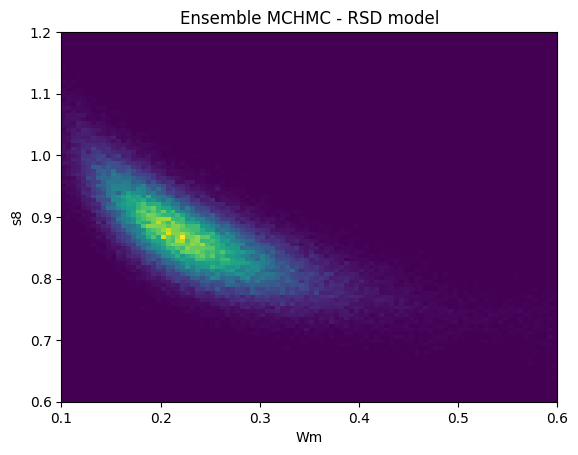

In [13]:
plt.hist2d(Wms_ensemble_mchmc, s8s_ensemble_mchmc, bins=100, range=[[0.1, 0.6],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("Ensemble MCHMC - RSD model");

##  AbstractMCMC

In [14]:
samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), 10000;
    dialog=true)

[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳


LoadError: DomainError with -0.33934227649544785:
sqrt will only return a complex result if called with a complex argument. Try sqrt(Complex(x)).

In [15]:
new_samples = sample(stat_model, MCHMC(varE_wanted=2.0), 10000; 
                     monitor_energy=true, 
                     progress=true, resume_from=samples)

LoadError: UndefVarError: `samples` not defined

## Ensemble AbstractMCMC

In [16]:
samples = sample(stat_model, MCHMC(100), 1000, 100)

[ Info: Burn-in started ⏳
[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
┌ Warning: L-tuning not Implemented
└ @ MicroCanonicalHMC ~/PhD/MicroCanonicalHMC.jl/src/ensemble/tuning.jl:41
[ Info: Found L: 1.4142135623730951 ✅
[ Info: VarE condition met during eps tuning at step: 13
[ Info: Found eps: 0.008664620420202015 ✅
[ Info: Virial loss condition met during burn-in at step: 2
[ Info: Found sigma: [1.620616898256196, 0.2532292543539198] ✅
┌ Warning: Maximum number of steps reached during eps tuning
└ @ MicroCanonicalHMC ~/PhD/MicroCanonicalHMC.jl/src/ensemble/tuning.jl:214
[ Info: Found eps: 0.0043824511407622386 ✅
Chain 1: 100%|██████████████████████████████████████████| Time: 0:00:04


Chains MCMC chain (100000×4×1 Array{Float64, 3}):

Iterations        = 1:1:100000
Number of chains  = 1
Samples per chain = 100000
Wall duration     = 6.0 seconds
Compute duration  = 6.0 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

          Ωm    0.2901    0.1673     0.0005    0.0088   233.6325    1.0001     ⋯
          σ8    0.7617    0.2533     0.0008    0.0133   232.2530    1.0074     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.0259    0.1396    0.2759    0.4387    0.5603
          σ8    0.3356    0.5914    0.7780    0.9295    1.2868


In [17]:
new_samples = sample(stat_model, MCHMC(100), 1000, 100; 
                     resume_from=samples)

[ Info: Starting from previous run
Chain 1: 100%|██████████████████████████████████████████| Time: 0:00:03


Chains MCMC chain (100000×4×1 Array{Float64, 3}):

Iterations        = 1:1:100000
Number of chains  = 1
Samples per chain = 100000
Wall duration     = 3.38 seconds
Compute duration  = 3.38 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

          Ωm    0.2404    0.0736     0.0002    0.0040   224.4534    1.0585     ⋯
          σ8    0.8627    0.0653     0.0002    0.0035   226.0813    1.0283     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.1345    0.1857    0.2350    0.2774    0.4314
          σ8    0.7524    0.8142    0.8569    0.9029    0.9855


## Parallelization

In [18]:
samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), MCMCThreads(), 30000, 4;
    monitor_energy=true, 
    dialog=true)

[ Info: number of chains: 4 smaller than number of threads: 10. Increase the number of chains to make full use of your threads.
[ Info: Tuning sigma ⏳
[ Info: Tuning sigma ⏳
[ Info: Tuning sigma ⏳
[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
[ Info: Tuning L ⏳
[ Info: Tuning L ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳


LoadError: TaskFailedException

[91m    nested task error: [39mDomainError with -0.33934227649544785:
    sqrt will only return a complex result if called with a complex argument. Try sqrt(Complex(x)).
    Stacktrace:
      [1] [0m[1mthrow_complex_domainerror[22m[0m[1m([22m[90mf[39m::[0mSymbol, [90mx[39m::[0mFloat64[0m[1m)[22m
    [90m    @[39m [90mBase.Math[39m [90m./[39m[90m[4mmath.jl:33[24m[39m
      [2] [0m[1msqrt[22m
    [90m    @[39m [90m./[39m[90m[4mmath.jl:677[24m[39m[90m [inlined][39m
      [3] [0m[1m_broadcast_getindex_evalf[22m
    [90m    @[39m [90m./[39m[90m[4mbroadcast.jl:683[24m[39m[90m [inlined][39m
      [4] [0m[1m_broadcast_getindex[22m
    [90m    @[39m [90m./[39m[90m[4mbroadcast.jl:656[24m[39m[90m [inlined][39m
      [5] [0m[1mgetindex[22m
    [90m    @[39m [90m./[39m[90m[4mbroadcast.jl:610[24m[39m[90m [inlined][39m
      [6] [0m[1mmacro expansion[22m
    [90m    @[39m [90m./[39m[90m[4mbroadcast.jl:974[24m[39m[90m [inlined][39m
      [7] [0m[1mmacro expansion[22m
    [90m    @[39m [90m./[39m[90m[4msimdloop.jl:77[24m[39m[90m [inlined][39m
      [8] [0m[1mcopyto![22m
    [90m    @[39m [90m./[39m[90m[4mbroadcast.jl:973[24m[39m[90m [inlined][39m
      [9] [0m[1mcopyto![22m
    [90m    @[39m [90m./[39m[90m[4mbroadcast.jl:926[24m[39m[90m [inlined][39m
     [10] [0m[1mcopy[22m
    [90m    @[39m [90m./[39m[90m[4mbroadcast.jl:898[24m[39m[90m [inlined][39m
     [11] [0m[1mmaterialize[22m[0m[1m([22m[90mbc[39m::[0mBase.Broadcast.Broadcasted[90m{Base.Broadcast.DefaultArrayStyle{1}, Nothing, typeof(sqrt), Tuple{Vector{Float64}}}[39m[0m[1m)[22m
    [90m    @[39m [90mBase.Broadcast[39m [90m./[39m[90m[4mbroadcast.jl:873[24m[39m
     [12] [0m[1mtune_sigma![22m[0m[1m([22m[90msampler[39m::[0mMicroCanonicalHMC.Sampler, [90mtarget[39m::[0mTuringTarget; [90mkwargs[39m::[0mBase.Pairs[90m{Symbol, Bool, Tuple{Symbol, Symbol}, NamedTuple{(:monitor_energy, :dialog), Tuple{Bool, Bool}}}[39m[0m[1m)[22m
    [90m    @[39m [35mMicroCanonicalHMC[39m [90m~/PhD/MicroCanonicalHMC.jl/src/[39m[90m[4mtuning.jl:89[24m[39m
     [13] [0m[1mtune_sigma![22m
    [90m    @[39m [90m~/PhD/MicroCanonicalHMC.jl/src/[39m[90m[4mtuning.jl:83[24m[39m[90m [inlined][39m
     [14] [0m[1mtune_hyperparameters[22m[0m[1m([22m[90msampler[39m::[0mMicroCanonicalHMC.Sampler, [90mtarget[39m::[0mTuringTarget, [90minit[39m::[0mTuple[90m{Vector{Float64}, Vector{Float64}, Float64, Vector{Float64}, Float64}[39m; [90mkwargs[39m::[0mBase.Pairs[90m{Symbol, Bool, Tuple{Symbol, Symbol}, NamedTuple{(:monitor_energy, :dialog), Tuple{Bool, Bool}}}[39m[0m[1m)[22m
    [90m    @[39m [35mMicroCanonicalHMC[39m [90m~/PhD/MicroCanonicalHMC.jl/src/[39m[90m[4mtuning.jl:155[24m[39m
     [15] [0m[1mmacro expansion[22m
    [90m    @[39m [90m~/PhD/MicroCanonicalHMC.jl/src/[39m[90m[4mabstractmcmc.jl:220[24m[39m[90m [inlined][39m
     [16] [0m[1m(::MicroCanonicalHMC.var"#902#threadsfor_fun#95"{MicroCanonicalHMC.var"#902#threadsfor_fun#84#96"{Base.Pairs{Symbol, Bool, Tuple{Symbol, Symbol}, NamedTuple{(:monitor_energy, :dialog), Tuple{Bool, Bool}}}, UnitRange{Int64}}})[22m[0m[1m([22m[90mtid[39m::[0mInt64; [90monethread[39m::[0mBool[0m[1m)[22m
    [90m    @[39m [35mMicroCanonicalHMC[39m [90m./[39m[90m[4mthreadingconstructs.jl:139[24m[39m
     [17] [0m[1m#902#threadsfor_fun[22m
    [90m    @[39m [90m./[39m[90m[4mthreadingconstructs.jl:106[24m[39m[90m [inlined][39m
     [18] [0m[1m(::Base.Threads.var"#1#2"{MicroCanonicalHMC.var"#902#threadsfor_fun#95"{MicroCanonicalHMC.var"#902#threadsfor_fun#84#96"{Base.Pairs{Symbol, Bool, Tuple{Symbol, Symbol}, NamedTuple{(:monitor_energy, :dialog), Tuple{Bool, Bool}}}, UnitRange{Int64}}}, Int64})[22m[0m[1m([22m[0m[1m)[22m
    [90m    @[39m [90mBase.Threads[39m [90m./[39m[90m[4mthreadingconstructs.jl:84[24m[39m

...and 3 more exceptions.


In [19]:
new_samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), MCMCThreads(), 30000, 4;
    monitor_energy=true, 
    dialog=true, 
    resume_from=samples)

[ Info: Starting from previous run


LoadError: MethodError: no method matching iterate(::Chains{Float64, AxisArrays.AxisArray{Float64, 3, Array{Float64, 3}, Tuple{AxisArrays.Axis{:iter, StepRange{Int64, Int64}}, AxisArrays.Axis{:var, Vector{Symbol}}, AxisArrays.Axis{:chain, UnitRange{Int64}}}}, Missing, NamedTuple{(:parameters, :internals), Tuple{Vector{Symbol}, Vector{Symbol}}}, NamedTuple{(:target, :sampler, :init, :start_time, :stop_time), Tuple{ParallelTarget, MicroCanonicalHMC.EnsembleSampler, Tuple{Tuple{Matrix{Float64}, Matrix{Float64}, Vector{Real}, Matrix{Real}, Vector{Float64}}, Tuple{Matrix{Real}, Vector{Float64}, Vector{Float64}}}, Float64, Float64}}})

[0mClosest candidates are:
[0m  iterate([91m::Union{LinRange, StepRangeLen}[39m)
[0m[90m   @[39m [90mBase[39m [90m[4mrange.jl:880[24m[39m
[0m  iterate([91m::Union{LinRange, StepRangeLen}[39m, [91m::Integer[39m)
[0m[90m   @[39m [90mBase[39m [90m[4mrange.jl:880[24m[39m
[0m  iterate([91m::T[39m) where T<:Union{Base.KeySet{<:Any, <:Dict}, Base.ValueIterator{<:Dict}}
[0m[90m   @[39m [90mBase[39m [90m[4mdict.jl:698[24m[39m
[0m  ...


## NUTS

In [20]:
samples_hmc = sample(stat_model, NUTS(10, 0.65),
                     10000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 0.05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:07


Chains MCMC chain (10000×14×1 Array{Float64, 3}):

Iterations        = 11:1:10010
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 11.66 seconds
Compute duration  = 11.66 seconds
parameters        = Ωm, σ8
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.2403    0.0683     0.0007    0.0017   1405.0343    1.0006    ⋯
          σ8    0.8637    0.0619     0.0006    0.0012   2356.8676    1.0002    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

     

In [21]:
samples_hmc.value

3-dimensional AxisArray{Float64,3,...} with axes:
    :iter, 11:1:10010
    :var, [:Ωm, :σ8, :lp, :n_steps, :is_accept, :acceptance_rate, :log_density, :hamiltonian_energy, :hamiltonian_energy_error, :max_hamiltonian_energy_error, :tree_depth, :numerical_error, :step_size, :nom_step_size]
    :chain, 1:1
And data, a 10000×14×1 Array{Float64, 3}:
[:, :, 1] =
 0.195289  0.931189  15.6471   7.0  1.0  …  2.0  0.0  0.0471045  0.0471045
 0.194965  0.891184  16.194    3.0  1.0     1.0  0.0  0.0471045  0.0471045
 0.20792   0.883536  16.2748  15.0  1.0     3.0  0.0  0.0471045  0.0471045
 0.252361  0.838644  16.1968  31.0  1.0     4.0  0.0  0.0471045  0.0471045
 0.251986  0.825046  16.0557   1.0  1.0     1.0  0.0  0.0471045  0.0471045
 0.24801   0.831916  16.1395   3.0  1.0  …  2.0  0.0  0.0471045  0.0471045
 0.195668  0.864144  15.9732  21.0  1.0     4.0  0.0  0.0471045  0.0471045
 0.264617  0.863147  15.8853  19.0  1.0     4.0  0.0  0.0471045  0.0471045
 0.272399  0.787847  15.258    7.0  1.0 

In [22]:
Wms_hmc = vec(samples_hmc["Ωm"])
s8s_hmc = vec(samples_hmc["σ8"]);

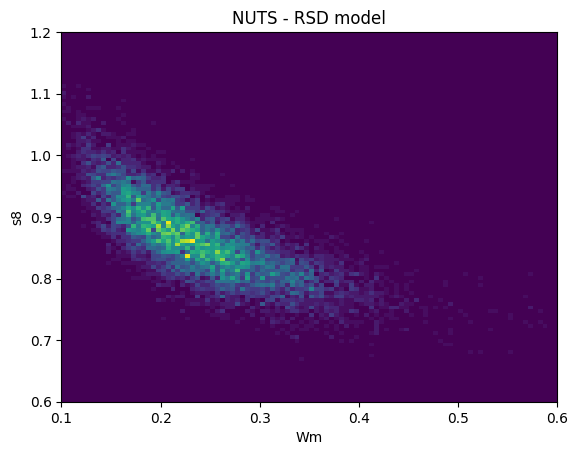

In [23]:
plt.hist2d(Wms_hmc, s8s_hmc, bins=100, range=[[0.1, 0.6],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("NUTS - RSD model");